# Hierarchical Clustering Part 2 - Complete Linkage and Characterization 
In this second notebook, we apply hierarchical clustering on the same data but use complete linkage we discuss how we can characterize/describe the clusters we computed. 

The notebook is an adaptation of 

https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

As before, we start by importing the required libraries and generate the same data we used in the previous notebook.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.datasets import make_blobs

# we are using the scipy implementation
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent

%matplotlib inline

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [8]:
random_state = 1234 ## another interesting example can be generated using the seed 36
no_clusters = 3
no_samples = 1500

X, y = make_blobs(centers=no_clusters, n_samples=no_samples, random_state=random_state)

Let's plot the blobs!

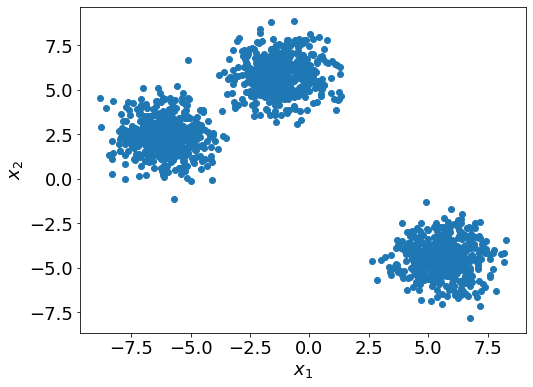

In [9]:
plt.figure(figsize=(8, 6));
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.scatter(X[:,0],X[:,1], cmap=plt.get_cmap('Pastel1'));
plt.xlabel("$x_1$");
plt.ylabel("$x_2$");
# plt.title("Data Points");

First, we generate the dendrogram using complete linkage and then plot the full dendrogram.

In [10]:
Z = linkage(X, 'complete')

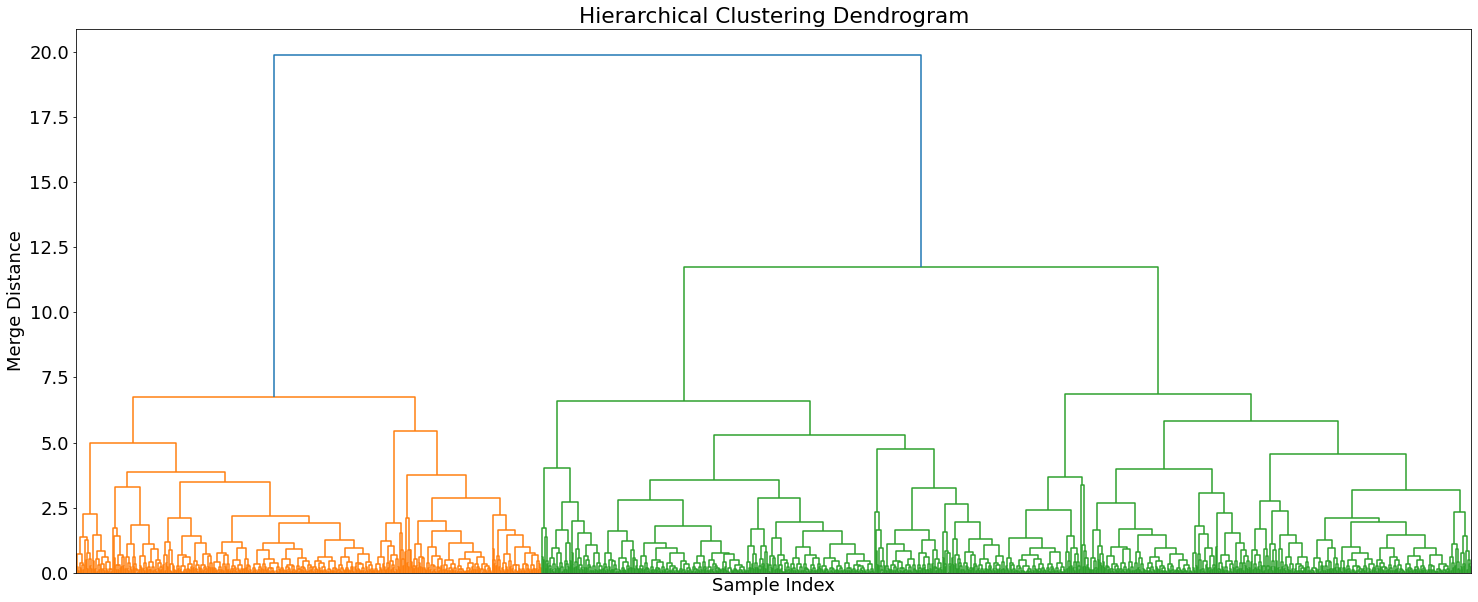

In [11]:
plt.figure(figsize=(25, 10))
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Merge Distance')
dendrogram(Z, 
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.xticks([])
plt.show()

## Knee/Elbow Analysis
To decide the number of cluster, let's plot the WSS and BSS curves and perform a knee/elbow analysis. For every k, we compute the clustering from the dendrogram z and compute WSS and BSS.

In [12]:
wss_values = []
bss_values = []
k_values = range(1,20)

for k in k_values:
    clustering = fcluster(Z, k, criterion='maxclust')
    centroids = [np.mean(X[clustering==c],axis=0) for c in range(1,k+1)]
    cdist(X, centroids, 'euclidean')
    D = cdist(X, centroids, 'euclidean')
    cIdx = np.argmin(D,axis=1)
    d = np.min(D,axis=1)

    avgWithinSS = sum(d)/X.shape[0]

    # Total with-in sum of square
    wss = sum(d**2)

    tss = sum(pdist(X)**2)/X.shape[0]
    
    bss = tss-wss
    
    wss_values += [wss]
    bss_values += [bss]

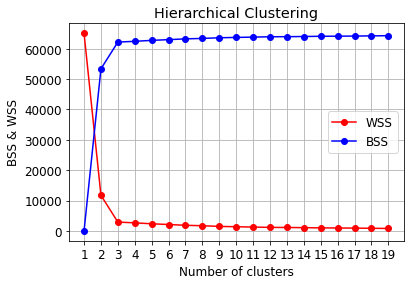

In [13]:
fig = plt.figure()
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)
plt.plot(k_values, wss_values, 'o-', color='red', label='WSS')
plt.plot(k_values, bss_values, 'o-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('BSS & WSS')
plt.xticks(k_values)
plt.legend()
plt.title('Hierarchical Clustering');

The plot for complete linkage shows a clear knee/elbow for three clusters. Let's check it also using the inconsistency coefficient with a depth of 5  and the acceleration. The former has a higher value for two clusters whereas acceleration confirm the elbow found with BSS/WSS for three clusters.

### Inconsistency Coefficient
The inconsistency coefficient compares the height of a link in a cluster hierarchy with the average height of links below it. Links that join distinct clusters have a high inconsistency coefficient; links that join indistinct clusters have a low inconsistency coefficient.

In [14]:
inconsistency = inconsistent(Z, d=5)

for i in reversed(range(1,15)):
    print("from %d to %d => Inconsistency %.3f"%(i,i+1,inconsistency[-i][3]))

from 14 to 15 => Inconsistency 2.768
from 13 to 14 => Inconsistency 3.134
from 12 to 13 => Inconsistency 3.203
from 11 to 12 => Inconsistency 3.431
from 10 to 11 => Inconsistency 3.173
from 9 to 10 => Inconsistency 2.960
from 8 to 9 => Inconsistency 2.926
from 7 to 8 => Inconsistency 3.377
from 6 to 7 => Inconsistency 3.267
from 5 to 6 => Inconsistency 2.915
from 4 to 5 => Inconsistency 2.987
from 3 to 4 => Inconsistency 2.879
from 2 to 3 => Inconsistency 3.737
from 1 to 2 => Inconsistency 4.294


### Acceleration

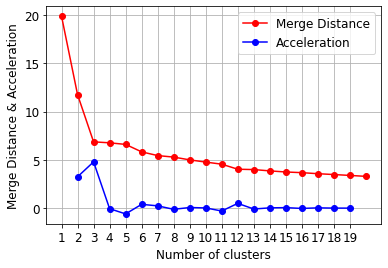

In [15]:
merge_distance = Z[-20:, 2]
reverse_merge_distance = merge_distance[::-1]
index = np.arange(1,len(merge_distance)+1)

acceleration = np.diff(merge_distance, 2)  # 2nd derivative of the distances
reversed_acceleration = acceleration[::-1]

fig = plt.figure()
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)
plt.plot(index, reverse_merge_distance, 'o-', color='red', label='Merge Distance')
plt.plot(index[:-2]+1, reversed_acceleration, 'o-', color='blue', label='Acceleration')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Merge Distance & Acceleration')
plt.xticks(k_values)
plt.legend()
# plt.title('Hierarchical Clustering');
plt.show();

In [ ]:
print("The number of cluster suggested using acceleration is %d"%(reversed_acceleration.argmax() + 2))

## Visualization of Clustering Solutions
It is interesting to analyze the last nine clustering to analyze how the data points were partitioned. 

In [ ]:
plt.figure(figsize=(12, 12));

for k in range(2,11):
    yp = fcluster(Z, k, criterion='maxclust')

    plt.subplot(330+(k-1))
    plt.title('k='+str(k))
    plt.scatter(X[:, 0], X[:, 1], c=yp,cmap=plt.get_cmap('Paired'))
    
plt.tight_layout()

# We can see from the plots that the clusters are not good as the example done before

## Describing the Clusters
Hierarchical clustering generates a hierarchy of possible clusterings. When we select k, we then generate the labels for all the data points. For instance, if we decide to use three clusters, our result will be a vector of 1500 labels. However, it would be difficult to understand the result of the clustering by looking at the raw labels and thus we need a way to describe those clusters in a succint way. Since the variables are numerical, for instance we can print for each cluster some summary statistics like mean, median, variance. So first, we create a data frame with the cluster information and then print some statistics by grouping the dataframe by the cluster label and then using the describe function.

In [ ]:
cdf = pd.DataFrame(columns = ['x1','x2'], data = X)
cdf['cluster'] = fcluster(Z, 3, criterion='maxclust')
cdf.groupby(by=['cluster']).describe()

We note that the three clusters are characterized by rather distinct values of the variables x1 and x2 since the mean and the variance of the two variables is very different. They have the same standard deviation (they were created using the same standard deviation). So we can use these values to create a narrative that can characterize our result to an audience. 